# Code

In [1]:
import pandas as pd
import os
import numpy as np
import sys
import pickle
from sklearn.model_selection import train_test_split

sys.path.insert(0, '..')
import dataset.train_test_val_utils as utils
from config import *

In [2]:
df_pairs_full = pd.read_csv(os.path.join(processed_files_dir, 'df_pairs_full.csv')).sample(frac=1).drop_duplicates().reset_index(drop = True)
df_genes = pd.read_csv(os.path.join(processed_files_dir, 'df_genes.csv'))

In [3]:
df = pd.read_csv(os.path.join(processed_files_dir, 'final_df.csv'))

### Stupid train test split 

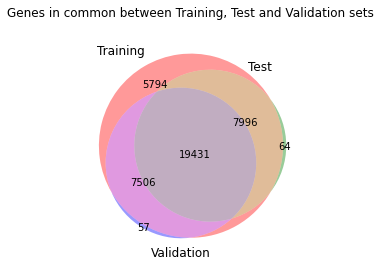

In [4]:
train_val, test = train_test_split(df_pairs_full, test_size=0.15)
train, val = train_test_split(train_val, test_size=0.18)

gene_pairs_training = list(set(train.positive).union(train.negative))
gene_pairs_test = list(set(val.positive).union(val.negative))
gene_pairs_val = list(set(test.positive).union(test.negative))
utils.venn_between_genes(gene_pairs_training, gene_pairs_test, gene_pairs_val)

# Proper train test split 

In [5]:
df_pairs_full['gene1'] = df_pairs_full.positive.str.split('_', expand = True)[0]
df_pairs_full['gene2'] = df_pairs_full.positive.str.split('_', expand = True)[1]

df_pairs_full['gene1_neg'] = df_pairs_full.negative.str.split('_', expand = True)[0]
df_pairs_full['gene2_neg'] = df_pairs_full.negative.str.split('_', expand = True)[1]

In [6]:
assert set(df_pairs_full.gene1).union(set(df_pairs_full.gene2)) == set(df_genes.gene_id)
assert set(df_pairs_full.gene1_neg).union(set(df_pairs_full.gene2_neg)) == set(df_genes.gene_id).union({np.nan})

In [7]:
df_pairs_full = df_pairs_full.merge(df_genes[['gene_id', 'species_set']], left_on = 'gene1', right_on = 'gene_id').drop('gene_id', axis = 1)

In [8]:
# df_pairs_full = df_pairs_full.merge(df_genes[['gene_id', 'species_set']], left_on = 'gene2', right_on = 'gene_id').drop('gene_id', axis = 1)
# assert (df_pairs_full.species_set_x == df_pairs_full.species_set_y).all()
# df_pairs_full = df_pairs_full.drop('species_set_x', axis = 1).rename({'species_set_y':'species_set'}, axis = 1)

In [9]:
rna_rna_files_dir = '/data01/gbini/projects/BERT-PARIS2/dataset/rna_rna_pairs/new4'

In [10]:
#circa 3 min
gene_pairs_training, gene_pairs_test, gene_pairs_val = utils.create_or_load_train_test_val(df_pairs_full, save_path = rna_rna_files_dir)

Total time: 0.0003934264183044434 minutes


### Some statistics and checks

In [ ]:
all_possible_pairs = set(df_pairs_full.positive).union(set(df_pairs_full.negative))
assert set(gene_pairs_training).union(set(gene_pairs_val)).union(set(gene_pairs_test)) == all_possible_pairs

print('tot:',len(all_possible_pairs))

print('- - - split - - -')

print('train:', len(set(gene_pairs_training)))

print('test:', len(set(gene_pairs_test)))

print('val:', len(set(gene_pairs_val)))

In [ ]:
# TODO: Esporta ora le liste, altrimenti c e un intersezione delle coppie tra i tre set

#one negative can be the same for 2 positives of the dataset. 
#If this happens, then I can have the same negative couple in the train, test, val sets.
#If this happens, then I take both the positive and the negative pair and I put them in the training set.

# neg_problematics = list(df_pairs_full[(df_pairs_full.negative.duplicated())&(~df_pairs_full.negative.isna())].negative)
# problematics = list(df_pairs_full[df_pairs_full.negative.isin(neg_problematics)][['positive', 'negative']].values.flatten())
# problematics = set(problematics)
# print(len(problematics))
# assert problematics - set(all_possible_pairs) == set()

# gene_pairs_training = list(set(gene_pairs_training).union(problematics) - set({np.nan}))
# gene_pairs_val = list(set(gene_pairs_val) - problematics.union(set({np.nan})))
# gene_pairs_test = list(set(gene_pairs_test) - problematics.union(set({np.nan})))

# assert set(gene_pairs_training).intersection(set(gene_pairs_val)) == set()
# assert set(gene_pairs_training).intersection(set(gene_pairs_test)) == set()
# assert set(gene_pairs_val).intersection(set(gene_pairs_test)) == set()

In [12]:
file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
df_train = pd.DataFrame({'couples':gene_pairs_train})
regex = df_train['couples'].str.extractall('(.*)_(.*)').reset_index()
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))
couples_train = set(df_train['couples'])

file_test = os.path.join(rna_rna_files_dir, "gene_pairs_test.txt")
with open(file_test, "rb") as fp:   # Unpickling
    gene_pairs_test = pickle.load(fp)
df_test = pd.DataFrame({'couples':gene_pairs_test})
regex = df_test['couples'].str.extractall('(.*)_(.*)').reset_index()
df_test['g1'] = regex[0]
df_test['g2'] = regex[1]
df_test_genes = set(df_test['g1']).union(set(df_test['g2']))
couples_test = set(df_test['couples'])

file_val = os.path.join(rna_rna_files_dir, "gene_pairs_val.txt")
with open(file_val, "rb") as fp:   # Unpickling
    gene_pairs_val = pickle.load(fp)
df_val = pd.DataFrame({'couples':gene_pairs_val})
regex = df_val['couples'].str.extractall('(.*)_(.*)').reset_index()
df_val['g1'] = regex[0]
df_val['g2'] = regex[1]
df_val_genes = set(df_val['g1']).union(set(df_val['g2']))
couples_val = set(df_val['couples'])

In [13]:
couples_test_val = couples_test.union(couples_val)
all_couples = couples_test_val.union(couples_train)

print(len(all_couples))
train_perc = np.round(len(couples_train)/len(all_couples)*100,2)
test_perc = np.round(len(couples_test)/len(all_couples)*100,2)
val_perc = np.round(len(couples_val)/len(all_couples)*100,2)
print(f'La percentuale di coppie nel training è {train_perc}')
print(f'La percentuale di coppie nel test è {test_perc}')
print(f'La percentuale di coppie nel validation è {val_perc}')

test_not_in_train = df_test[~(df_test.g1.isin(df_train_genes) | df_test.g2.isin(df_train_genes))]
test_not_in_train = set(test_not_in_train.couples)
val_not_in_train = df_val[~(df_val.g1.isin(df_train_genes) | df_val.g2.isin(df_train_genes))]
val_not_in_train = set(val_not_in_train.couples)

perc_test_notrain = np.round(len(test_not_in_train)/len(couples_test)*100, 2)
perc_val_notrain = np.round(len(val_not_in_train)/len(couples_val)*100, 2)

print(f'La percentuale di coppie nel test non nel training (rispetto al totale del test set) è {perc_test_notrain}')
print(f'La percentuale di coppie nel validation non nel training (rispetto al totale del validation set) è {perc_val_notrain}')
print(f'Il numero di coppie nel test non nel training è {len(test_not_in_train)}')
print(f'Il numero di coppie nel test (positive) non nel training è  {len(set(df[df.couples.isin(test_not_in_train)&df.interacting].couples))}')
print(f'Il numero di coppie nel val non nel training è {len(val_not_in_train)}')
print(f'Il numero di coppie nel val (positive) non nel training è  {len(set(df[df.couples.isin(val_not_in_train)&df.interacting].couples))}')

240643
La percentuale di coppie nel training è 72.61
La percentuale di coppie nel test è 13.81
La percentuale di coppie nel validation è 13.58
La percentuale di coppie nel test non nel training (rispetto al totale del test set) è 3.08
La percentuale di coppie nel validation non nel training (rispetto al totale del validation set) è 2.51
Il numero di coppie nel test non nel training è 1023
Il numero di coppie nel test (positive) non nel training è  344
Il numero di coppie nel val non nel training è 819
Il numero di coppie nel val (positive) non nel training è  280


# RES
new: 249, 281
new2: 255, 284
new3: 304, 209
new4: 344, 280
new5: 273, 242

### Plots and stats

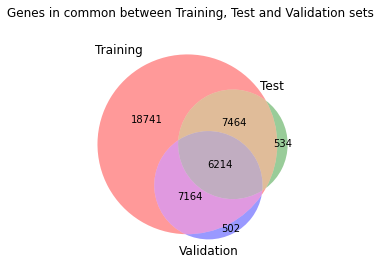

In [14]:
utils.venn_between_genes(gene_pairs_training, gene_pairs_test, gene_pairs_val)

In [15]:
#Percentage of train-test-validation
perc_train = np.round(len(gene_pairs_training)/len(all_possible_pairs), 2)
perc_test = np.round(len(gene_pairs_test)/len(all_possible_pairs), 2)
perc_val = np.round(len(gene_pairs_val)/len(all_possible_pairs), 2)
print(f'{perc_train=}')
print(f'{perc_test=}')
print(f'{perc_val=}')

perc_train=0.73
perc_test=0.14
perc_val=0.14


In [36]:
print(f'La lunghezza media è {np.round(df_genes.length.mean(),2)}')
print(f'La lunghezza mediana è {np.round(df_genes.length.median(),2)}')
print(f'La lunghezza minima è {df_genes.length.min()}')
print(f'I 10 rna piu corti sono corti:', str(df_genes.sort_values('length').head(10).length.values))
print(f'La lunghezza massima è {df_genes.length.max()}')

La lunghezza media è 3367.15
La lunghezza mediana è 2705.0
La lunghezza minima è 49
I 10 rna piu corti sono corti: [49 50 53 63 72 75 85 87 94 98]
La lunghezza massima è 205012


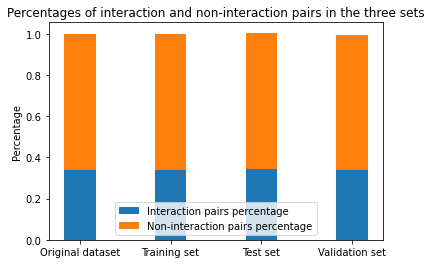

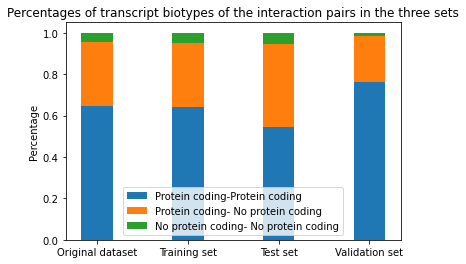

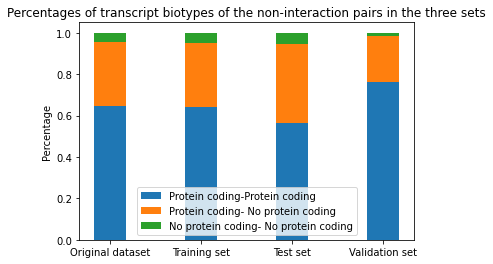

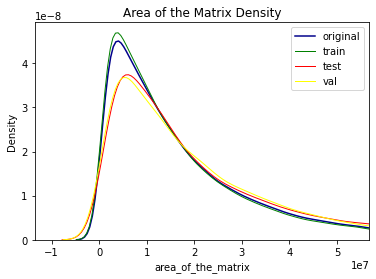

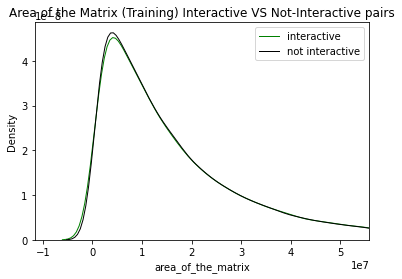

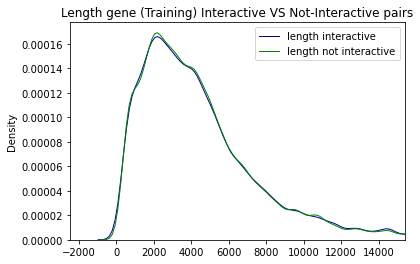

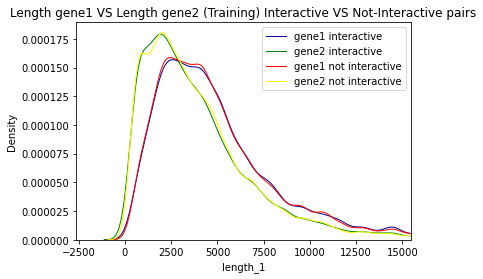

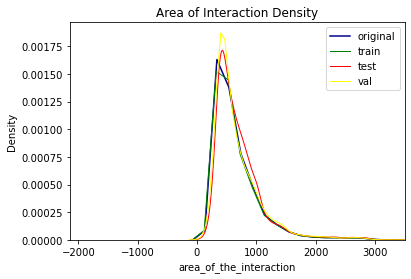

In [16]:
utils.plot_stats(df, gene_pairs_training, gene_pairs_test, gene_pairs_val, limit_plot = 100000000)